In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\AntonioDias\AppData\Local\Temp\ipykernel_18496\3632437423.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
filepath = 'data/train.csv'
df = pd.read_csv(filepath)


In [3]:
data = df.copy()

In [4]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Exploratory Data Analysis

In [5]:
# size of dataset
data.shape

(8693, 14)

In [6]:
# information about features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
# categorical variables
categorical_features = [col for col in data.select_dtypes(include=['object']).columns]
print (categorical_features)

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']


In [8]:
# numerical variables
numerical_features = [col for col in data.select_dtypes(include=['number']).columns]
print (numerical_features)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [9]:
# number of duplicated rows
data.duplicated().sum()

0

In [10]:
# percentage of missing data per column
data.isna().mean()*100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

Most columns have ~2% of missing values. There are multiple strategies of dealing with missing data, the most simple being to drop those observations:

In [11]:
# percentage of data loss by dropping observations with missing data
data_loss = 1 - (data.dropna().shape[0]/data.shape[0])
print (f"By dropping rows with missing data we lose {round(data_loss,2)*100}% of the original dataset size")

By dropping rows with missing data we lose 24.0% of the original dataset size


Dropping observations with missing information leads to a considerable loss in the size of the dataset, so I'll try to see if I can fill in the missing data for some of these features

In [12]:
# describe data (numerical variables)
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [13]:
# describe data (categorical variables)
data.describe(include=[object])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


#### Transported

In [14]:
# Percentage of passengers who were Transported
data['Transported'].value_counts(dropna=False, normalize=True)*100

Transported
True     50.362361
False    49.637639
Name: proportion, dtype: float64

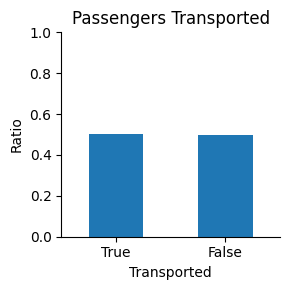

In [15]:
data['Transported'].value_counts(dropna=False, normalize=True).plot.bar(rot=0, figsize=(3,3))
plt.ylim(0,1)
plt.ylabel('Ratio')
plt.title('Passengers Transported')

sns.despine()
plt.tight_layout()

It seems the dataset is well balanced in terms of the target feature, with ~50% of passengers beings Tranported.

#### PassangerId
A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

In [16]:
data['PassengerId'].nunique()

8693

Since the PassengerId column contains information about the group each individual passenger is travelling with, I'll extract that information to have an idea of how many groups are in the dataset

In [17]:
data['Group']=data['PassengerId'].str.split('_').str[0]
print (f"There are {data['Group'].nunique()} groups of passengers in the dataset")

There are 6217 groups of passengers in the dataset


In [18]:
# distribuition of groups by number of passengers
pd.cut(data['Group'].value_counts(dropna=False),bins=5).value_counts()

count
(0.993, 2.4]    5646
(2.4, 3.8]       340
(3.8, 5.2]       156
(6.6, 8.0]        46
(5.2, 6.6]        29
Name: count, dtype: int64

In [19]:
#data['Group'].value_counts().hist(grid=False)

#### HomePlanet

In [20]:
data['HomePlanet'].value_counts(dropna=False)

HomePlanet
Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: count, dtype: int64

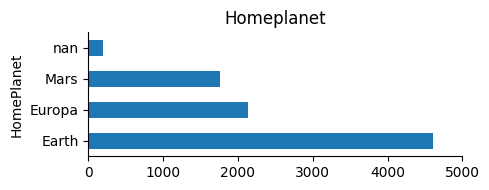

In [21]:
plt.figure(figsize=(5,2))
plt.title('Homeplanet')
data['HomePlanet'].value_counts(dropna=False).plot.barh()

plt.xlim(0,5000)

sns.despine()
plt.tight_layout()

Are there differences in the % of Transported passengers based on their Homeplanet?

In [22]:
data.groupby(by=['HomePlanet'],dropna=False).Transported.value_counts(dropna=False, normalize=True)*100

HomePlanet  Transported
Earth       False          57.605389
            True           42.394611
Europa      True           65.884561
            False          34.115439
Mars        True           52.302445
            False          47.697555
NaN         True           51.243781
            False          48.756219
Name: proportion, dtype: float64

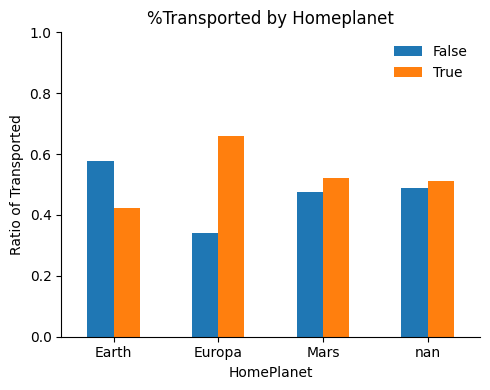

In [23]:
data.groupby(by=['HomePlanet'],dropna=False).Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(5,4))
plt.title('%Transported by Homeplanet')

plt.ylim(0,1)
plt.ylabel('Ratio of Transported')

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

Interestingly it seems that passengers from Europa are more likely to be Transported than not

#### CryoSleep

In [24]:
data.CryoSleep.value_counts(dropna=False)

CryoSleep
False    5439
True     3037
NaN       217
Name: count, dtype: int64

In [25]:
data.groupby(by=['CryoSleep'],dropna=False).Transported.value_counts(dropna=False, normalize=True)*100

CryoSleep  Transported
False      False          67.107924
           True           32.892076
True       True           81.758314
           False          18.241686
NaN        False          51.152074
           True           48.847926
Name: proportion, dtype: float64

Since the CryoSleep feature relates to whether or not passengers had elected to be put to sleep during the entire duration of the voyage, I expected that passengers these passengers were less likely to be rescued (since they were confined to their cabins). 

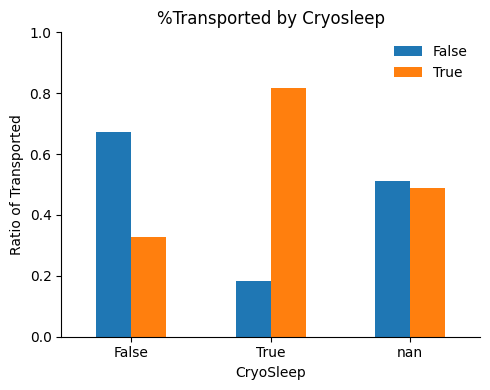

In [26]:
data.groupby(by=['CryoSleep'],dropna=False).Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(5,4))
plt.title('%Transported by Cryosleep')

plt.ylim(0,1)
plt.ylabel('Ratio of Transported')

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

In fact, the opposite seems to be true, as passengers who were not put in Cryosleep are least likely to be rescued, whereas passengers in Cryosleep are much more likely to be rescued.

Since being put in Cryosleep is probably expensive, I investigated whether VIP passengers were more likely to be in suspended animation during the voyage

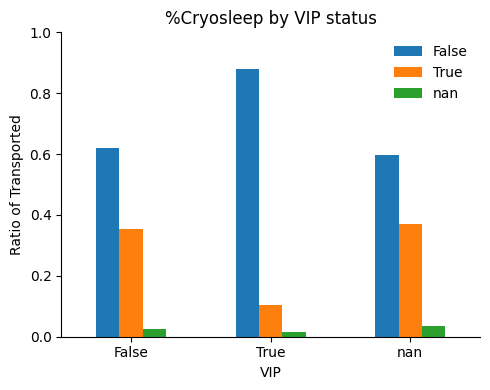

In [27]:
data.groupby(by=['VIP'],dropna=False).CryoSleep.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(5,4))
plt.title('%Cryosleep by VIP status')

plt.ylim(0,1)
plt.ylabel('Ratio of Transported')

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

Once again, the opposite seems to be True since as VIP passengers are less likely to not be put in Cryosleep.

#### Cabin

The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [28]:
data.Cabin.value_counts(dropna=False)

Cabin
NaN        199
G/734/S      8
C/137/S      7
B/201/P      7
G/109/P      7
          ... 
G/556/P      1
E/231/S      1
G/545/S      1
G/543/S      1
C/178/S      1
Name: count, Length: 6561, dtype: int64

In [29]:
print (f"The spaceship has {data.Cabin.nunique()} unique cabins")

The spaceship has 6560 unique cabins


Since the "Cabin" feature has information about deck, number and side of the cabin where each passenger is statying, I'll be creating 3 distinct features based on "Cabin" to see if we can indetify any interesting patterns.

In [30]:
# Create Deck, Number and Side features from Cabin
data[['Deck', 'Number', 'Side']] = data['Cabin'].str.split('/', expand=True)

In [31]:
# check that transformation of Cabin feature worked
data[['Cabin','Deck','Number','Side']].head()

,Cabin,Deck,Number,Side
0,B/0/P,B,0,P
1,F/0/S,F,0,S
2,A/0/S,A,0,S
3,A/0/S,A,0,S
4,F/1/S,F,1,S


In [32]:
data.Deck.value_counts(dropna=False)

Deck
F      2794
G      2559
E       876
B       779
C       747
D       478
A       256
NaN     199
T         5
Name: count, dtype: int64

Most passengers are from Decks "F" and "G". Are the passengers from any particular deck more likely to be transported?

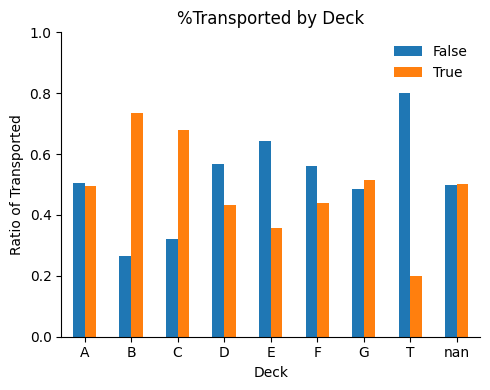

In [33]:
data.groupby(by=['Deck'],dropna=False).Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(5,4))
plt.title('%Transported by Deck')

plt.ylim(0,1)
plt.ylabel('Ratio of Transported')

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

The passengers in decks "B" and "C" are more likely to be Transported than passengers in other decks. Passengers in deck "T" (while only being 5), appear less likely to be rescued. 

##### Number

In [34]:
data.Number.nunique()

1817

At a first glance the "Number" of the cabin where the passengers are staying might not be directly related to whether or not it gets transported. However, similar to the "Deck" feature the cabin "Number" might hide some correlations, such as:

1. If the spaceship is split in half, with even cabin numbers on one side and odd numbers on the other, than maybe passengers from one side of the spaceship are more likely to be transported following the collision.

2. If smaller numbers are more common on "one side" of the spaceship (port-side for example), than maybe passengers on one end of the spaceship are more likely to be transported compared to the passengers on the other end of the ship.

In [35]:
# convert "Number" column to numeric
data['Number'] = data['Number'].astype('Int64')

In [36]:
# create Even_Odd column based on whether the cabin number is even or odd
data['Even_Odd'] = data['Number'].apply(lambda x: 'Odd' if x % 2 else 'Even')

In [37]:
data['Even_Odd'].value_counts(dropna=False)

Even_Odd
Odd     4484
Even    4209
Name: count, dtype: int64

In [38]:
data.groupby(by=['Even_Odd'],dropna=False).Transported.value_counts(dropna=False, normalize=True)*100

Even_Odd  Transported
Even      False          50.463293
          True           49.536707
Odd       True           51.137377
          False          48.862623
Name: proportion, dtype: float64

It seems being on an even or odd numbered cabin has no influence on whether the passengers are transported.

#### Side

In [39]:
data['Side'].value_counts(dropna=False)

Side
S      4288
P      4206
NaN     199
Name: count, dtype: int64

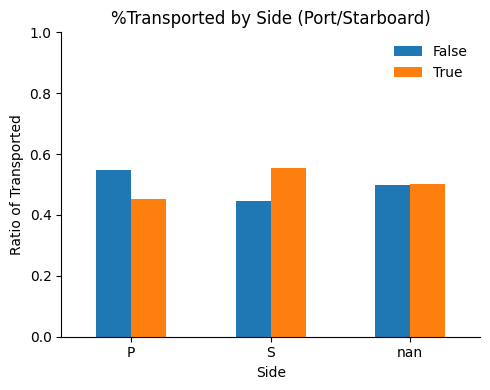

In [40]:
data.groupby(by=['Side'],dropna=False).Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(5,4))
plt.title('%Transported by Side (Port/Starboard)')

plt.ylim(0,1)
plt.ylabel('Ratio of Transported')

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

It seems passengers with cabins on the Starboard-side of the ship are (slightly) more likely to get transported than those with cabins on the Port-side.

#### Destination

In [41]:
data.Destination.value_counts(dropna=False)

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
NaN               182
Name: count, dtype: int64

In [42]:
data.groupby(by=['Destination'],dropna=False).Transported.value_counts(dropna=False, normalize=True)*100

Destination    Transported
55 Cancri e    True           61.000000
               False          39.000000
PSO J318.5-22  True           50.376884
               False          49.623116
TRAPPIST-1e    False          52.882502
               True           47.117498
NaN            True           50.549451
               False          49.450549
Name: proportion, dtype: float64

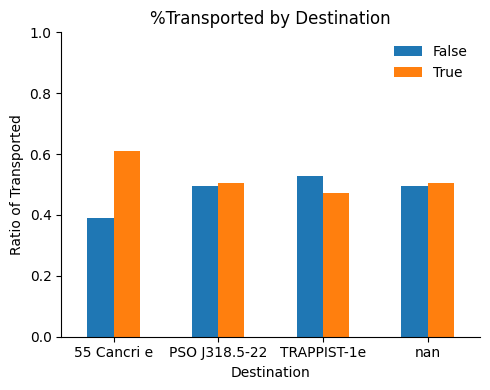

In [43]:
data.groupby(by=['Destination'],dropna=False).Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(5,4))
plt.title('%Transported by Destination')

plt.ylim(0,1)
plt.ylabel('Ratio of Transported')

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

Passengers who have "55 Cancri e" as their destination are slightly more likely to be Transported (in comparison with the other destinations).

#### VIP

In [44]:
data.VIP.value_counts(dropna=False)

VIP
False    8291
NaN       203
True      199
Name: count, dtype: int64

In [45]:
data.groupby(by=['VIP'],dropna=False).Transported.value_counts(dropna=False, normalize=True)*100

VIP    Transported
False  True           50.633217
       False          49.366783
True   False          61.809045
       True           38.190955
NaN    True           51.231527
       False          48.768473
Name: proportion, dtype: float64

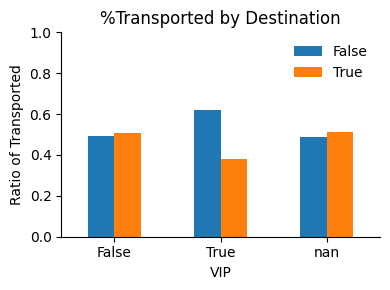

In [46]:
data.groupby(by=['VIP'],dropna=False).Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(4,3))
plt.title('%Transported by Destination')

plt.ylim(0,1)
plt.ylabel('Ratio of Transported')

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

Unlike what one might expect, being a VIP passenger does not appear to be correlated with increased chances of being Transported. In fact, among VIP passengers only 40% were Transported, while among non-VIP passengers the percentage of passengers rescued was closer to 50%.

### NUMERICAL FEATURES

In [47]:
data[numerical_features].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


#### Age

In [48]:
data['Age'].isna().sum()

179

We also have 179 passengers without information regarding their age.

In [49]:
data['Age'].describe()

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

In [50]:
data[data['Age']==0].shape[0]

178

From the distribuition of the Age feature we could see that the minimum Age in the dataset is 0, suggesting that there might be some "newborns" on board the spaceship. After checking the number of passengers that had "0" as their age we found that indeed **178 passengers are babies**.

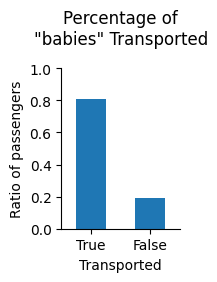

In [51]:
# Distribution of rescued "babies" 
data[data['Age']==0].Transported.value_counts(normalize=True).plot.bar(figsize=(2,3), rot=0)
plt.title('Percentage of\n"babies" Transported', y=1.1)
plt.ylim(0,1)
plt.ylabel('Ratio of passengers')
sns.despine()
plt.tight_layout()

As we might have predicted, we can see that the majority of babies (~80%) were rescued/transported after the ship's collision.

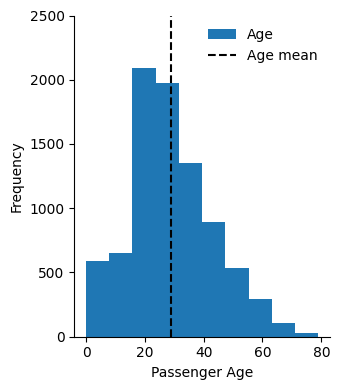

In [52]:
# Distribuition of the Age feature
plt.figure(figsize=(3.5,4))
data['Age'].plot.hist()
plt.axvline(x=data['Age'].mean(), ls='dashed', c='k', label='Age mean')
plt.legend(frameon=False, ncols=1)
plt.xlabel('Passenger Age')
plt.ylim(0,2500)
sns.despine()
plt.tight_layout()

For the purpose of exploration, I'll also investigate if any particular "Age group" is more likely to get rescued

In [53]:
bins= [0,2,4,13,20,60,80]
labels = ['Baby','Toddler','Kid','Teen','Adult','Senior']

In [54]:
data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

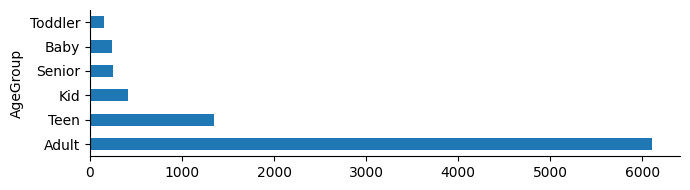

In [55]:
data['AgeGroup'].value_counts(sort=True).plot.barh(figsize=(7,2))
sns.despine()
plt.tight_layout()

In [56]:
data['AgeGroup'].value_counts(normalize=True)*100

AgeGroup
Adult      71.670190
Teen       15.879728
Kid         4.827343
Senior      2.983322
Baby        2.877613
Toddler     1.761804
Name: proportion, dtype: float64

The vast majority of passengers (~72%) on board are Adults (between 20 and 60 years old), followed by Teens (between 13 and 20 years old) who represent ~16% of the population on board.

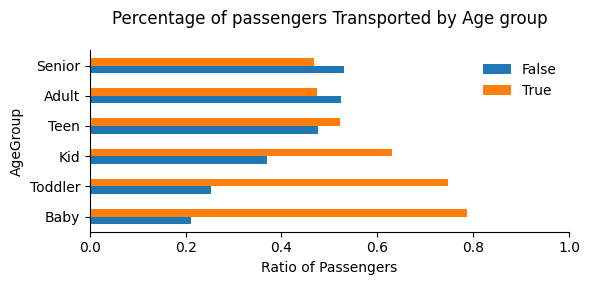

In [57]:
data.groupby('AgeGroup', observed=True).Transported.value_counts(normalize=True, sort=True).unstack().plot.barh(figsize=(6,3))
plt.title('Percentage of passengers Transported by Age group', y=1.1)
plt.legend(frameon=False)
plt.xlim(0,1)
plt.xlabel('Ratio of Passengers')
sns.despine()
plt.tight_layout()

In [58]:
data.groupby('AgeGroup', observed=True).Transported.value_counts(normalize=True, sort=True)*100

AgeGroup  Transported
Baby      True           78.775510
          False          21.224490
Toddler   True           74.666667
          False          25.333333
Kid       True           63.017032
          False          36.982968
Teen      True           52.292899
          False          47.707101
Adult     False          52.507375
          True           47.492625
Senior    False          53.149606
          True           46.850394
Name: proportion, dtype: float64

As expected, we can see that younger passengers (Babies, Toddlers and Kids) are significantly more likely to be rescued that not. This suggests that rescuing these passengers might have been prioritized following the ship's collision. On the other hand, older passengers (Teens, Adults and Seniors) have ~50% of chances of being rescued.

### RoomService

In [59]:
data['RoomService'].describe()

count     8512.000000
mean       224.687617
std        666.717663
min          0.000000
25%          0.000000
50%          0.000000
75%         47.000000
max      14327.000000
Name: RoomService, dtype: float64

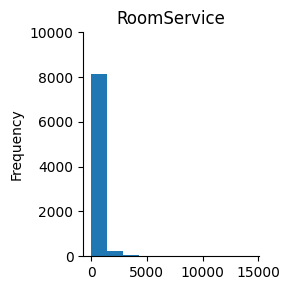

In [60]:
# Distribuition of RoomService spending feature
data['RoomService'].plot.hist(figsize=(3,3))
plt.title('RoomService')
plt.ylim(0,10000)
sns.despine()
plt.tight_layout()

In [61]:
# How many passengers spend more than 1k on RoomService?
data[data['RoomService']>1000].shape[0]

600

It seems the majority of passengers don't spend a lot of money on RoomService, since 75% of passengers spend 47$ or less. However, there is a non-insignificant part of the population that spends significant sums of money on RoomService (at least one passenger spends more than 14k$).

I decided to investigate these passengers that spent significant amounts of money to check if perhaps they were more likely to be rescued:

In [62]:
data['Bigspenders_RoomService'] = data['RoomService'].apply(lambda x: 1 if x>1000 else 0)

In [63]:
# How many passengers spend more than 1k on RoomService?
data[data['RoomService']>1000].shape[0]

600

In [64]:
data.groupby('Bigspenders_RoomService').Transported.value_counts(dropna=False)

Bigspenders_RoomService  Transported
0                        True           4300
                         False          3793
1                        False           522
                         True             78
Name: count, dtype: int64

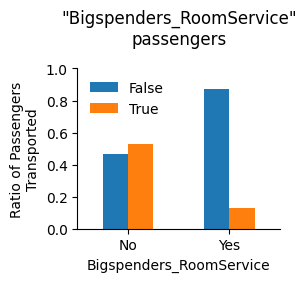

In [65]:
data.groupby('Bigspenders_RoomService').Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(3,3))
plt.title('"Bigspenders_RoomService"\npassengers', y=1.1)
plt.ylim(0,1)
plt.ylabel('Ratio of Passengers\nTransported')
plt.xticks([0,1], ['No','Yes'])
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

In [66]:
data.groupby('Bigspenders_RoomService').Transported.value_counts(dropna=False, normalize=True)*100

Bigspenders_RoomService  Transported
0                        True           53.132337
                         False          46.867663
1                        False          87.000000
                         True           13.000000
Name: proportion, dtype: float64

Suprisingly, it seems passengers who spent a lot of money on 'Room Service' (>1k$) are significantly more likely to NOT be rescued.

My next question was whether we found a similar trend in the other "money-spending" features, such as "FoodCourt" (how much money a passenger spent on the Foodcourt alley) and "ShoppingMall" (how much money a passenger spent Shopping).

### Foodcourt

In [67]:
data['FoodCourt'].describe()

count     8510.000000
mean       458.077203
std       1611.489240
min          0.000000
25%          0.000000
50%          0.000000
75%         76.000000
max      29813.000000
Name: FoodCourt, dtype: float64

In [68]:
# How many passengers spend more than 10k on Foodcourt?
data[data['FoodCourt']>10000].shape[0]

52

In [69]:
data['Bigspenders_Food'] = data['FoodCourt'].apply(lambda x: 1 if x>10000 else 0)

In [70]:
data.groupby('Bigspenders_Food').Transported.value_counts(dropna=False, normalize=True)*100

Bigspenders_Food  Transported
0                 True           50.214096
                  False          49.785904
1                 True           75.000000
                  False          25.000000
Name: proportion, dtype: float64

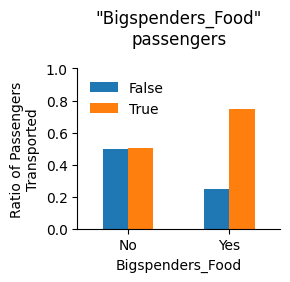

In [71]:
data.groupby('Bigspenders_Food').Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(3,3))
plt.title('"Bigspenders_Food"\npassengers', y=1.1)
plt.ylim(0,1)
plt.ylabel('Ratio of Passengers\nTransported')
plt.xticks([0,1], ['No','Yes'])
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

In [72]:
data.groupby('Bigspenders_Food').Transported.value_counts(dropna=False, normalize=True)*100

Bigspenders_Food  Transported
0                 True           50.214096
                  False          49.785904
1                 True           75.000000
                  False          25.000000
Name: proportion, dtype: float64

Unlike the passengers that spent a lot of money on "RoomService", we find the opposite trend in the passengers that spent a lot of money on food. Overall, passengers that spent more than 10k (N=52) on food are significantly more likely to be Transported than not.

### Shopping Mall

In [73]:
data['ShoppingMall'].describe()

count     8485.000000
mean       173.729169
std        604.696458
min          0.000000
25%          0.000000
50%          0.000000
75%         27.000000
max      23492.000000
Name: ShoppingMall, dtype: float64

In [74]:
# How many passengers spend more than 2k on ShoppingMall?
data[data['ShoppingMall']>2000].shape[0]

124

In [75]:
data['Bigspenders_Mall'] = data['ShoppingMall'].map(lambda x: 1 if x>2000 else 0)

In [76]:
data.groupby('Bigspenders_Mall').Transported.value_counts()

Bigspenders_Mall  Transported
0                 True           4287
                  False          4282
1                 True             91
                  False            33
Name: count, dtype: int64

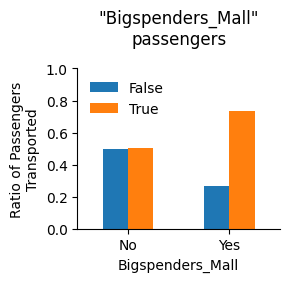

In [77]:
data.groupby('Bigspenders_Mall').Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(3,3))
plt.title('"Bigspenders_Mall"\npassengers', y=1.1)
plt.ylim(0,1)
plt.ylabel('Ratio of Passengers\nTransported')
plt.xticks([0,1], ['No','Yes'])
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

In [78]:
data.groupby('Bigspenders_Mall').Transported.value_counts(dropna=False, normalize=True)*100

Bigspenders_Mall  Transported
0                 True           50.029175
                  False          49.970825
1                 True           73.387097
                  False          26.612903
Name: proportion, dtype: float64

Similar to what we had found to be the case in the "FoodCourt" feature, we find that the passengers that spent a lot of money on the "ShoppingMall" are also more likely to be rescued. In fact, passengers that spent more than 2k (N=124) on shopping had a 73% probability of being rescued (compared to ~50% in those that spent up to 2k).

The analysis shown above suggests that how much money the passengers spent on the different areas of the ship seems to correlate with their likelihood of being transported since:
- Passengers that spent a lot of money on RoomService were less likely to be transported;
- Passengers that spent a lot of money on either the ShoppingMall or the FoodCourt were more likely to be transported;

We can use this analysis to build some extra features that can help improve the performance of our classification model.

### SPA

In [79]:
data['Spa'].describe()

count     8510.000000
mean       311.138778
std       1136.705535
min          0.000000
25%          0.000000
50%          0.000000
75%         59.000000
max      22408.000000
Name: Spa, dtype: float64

In [80]:
# How many passengers spend more than 1k on SPA?
data[data['Spa']>1000].shape[0]

629

In [81]:
data['Bigspenders_Spa'] = data['Spa'].map(lambda x: 1 if x>1000 else 0)

In [82]:
data.groupby('Bigspenders_Spa').Transported.value_counts()

Bigspenders_Spa  Transported
0                True           4308
                 False          3756
1                False           559
                 True             70
Name: count, dtype: int64

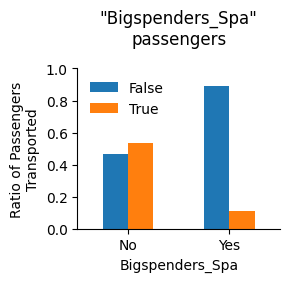

In [83]:
data.groupby('Bigspenders_Spa').Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(3,3))
plt.title('"Bigspenders_Spa"\npassengers', y=1.1)
plt.ylim(0,1)
plt.ylabel('Ratio of Passengers\nTransported')
plt.xticks([0,1], ['No','Yes'])
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

In [84]:
data.groupby('Bigspenders_Spa').Transported.value_counts(dropna=False, normalize=True)*100

Bigspenders_Spa  Transported
0                True           53.422619
                 False          46.577381
1                False          88.871224
                 True           11.128776
Name: proportion, dtype: float64

Interestingly, and similar to what we had seen in the RoomService feature, the passengers who spent a lot of money on the Spa (>1k$) are significantly more likely to NOT be rescued.

### VRDeck

In [85]:
data['VRDeck'].describe()

count     8505.000000
mean       304.854791
std       1145.717189
min          0.000000
25%          0.000000
50%          0.000000
75%         46.000000
max      24133.000000
Name: VRDeck, dtype: float64

In [86]:
# How many passengers spend more than 1k on the VRDeck?
data[data['VRDeck']>1000].shape[0]

621

In [87]:
data['Bigspenders_VR'] = data['VRDeck'].map(lambda x: 1 if x>1000 else 0)

In [88]:
data.groupby('Bigspenders_VR').Transported.value_counts()

Bigspenders_VR  Transported
0               True           4303
                False          3769
1               False           546
                True             75
Name: count, dtype: int64

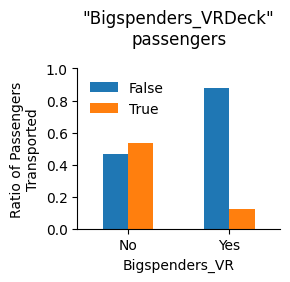

In [89]:
data.groupby('Bigspenders_VR').Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(3,3))
plt.title('"Bigspenders_VRDeck"\npassengers', y=1.1)
plt.ylim(0,1)
plt.ylabel('Ratio of Passengers\nTransported')
plt.xticks([0,1], ['No','Yes'])
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

Interestingly, and similar to what we had seen in the RoomService and SPA features, the passengers who spent a lot of money on the VRDeck (>1k$) are also significantly more likely to NOT be rescued.

#### Fill missing values in RoomService/FoodCourt/ShoppingMall

In [90]:
# How many missing values do we have for each of the "money spending features" ?
data[['RoomService','FoodCourt','ShoppingMall']].isna().sum()

RoomService     181
FoodCourt       183
ShoppingMall    208
dtype: int64

The features realted with "money spending" (RoomService, Foodcourt and ShoppingMall) have a lot of missing values. I wanted to investigate if we can fill some of those missing values by investigating other features, such as "CryoSleep" since if a passenger is being kept on Cryosleep then he isn't spending any money on the ship. 

In [91]:
# How many of those passengers were in a state of Cryosleep?
data[data['CryoSleep']==True][['RoomService','FoodCourt','ShoppingMall']].isna().sum()

RoomService     68
FoodCourt       70
ShoppingMall    96
dtype: int64

We can see that for most of the features mentioned above, between 1/3 and 1/2 of the passengers with missing values in the "money spending features" are also in CryoSleep. This suggests that perhaps I could use this information to fill these 3 features with zeros for all the passengers in CryoSleep.

However, for this logic to make sense, then the passengers that didn't spend money 1 one area of the ship (perhaps because they were in Cryosleep), then they must have also not spent any money on the other areas of the ship... I decided to investigate that below by looking at the passengers that had missing values in the RoomService feature:

In [92]:
# Count instances where RoomService is NaN, FoodCourt is 0, and ShoppingMall is 0
data[['RoomService','FoodCourt','ShoppingMall']].isna().all(axis=1).sum()

0

As we can see, our theory isn't 100% correct since there aren't any passenges that have NaN (missing information) in all 3 FoodCourt, ShoppingMall and RoomService features. This suggests that those passengers that have missing information in any of these 3 columns isn't necessarily because they were not spending money in any area of the ship (due to being in CryoSleep like we suspected).


In [93]:
# Count instances where RoomService is NaN, FoodCourt is 0, and ShoppingMall is 0
count_nan_zero_zero = data[(data['RoomService'].isna()) & (data['FoodCourt'] == 0) & (data['ShoppingMall'] == 0)].shape[0]

# Count instances where RoomService is NaN, FoodCourt is greater than 0, and ShoppingMall is greater than 0
count_nan_greater_than_zero = data[(data['RoomService'].isna()) & (data['FoodCourt'] > 0) & (data['ShoppingMall'] > 0)].shape[0]

print(f"Count where RoomService is NaN but FoodCourt and ShoppingMall are 0: {count_nan_zero_zero}")
print(f"Count where RoomService is NaN but FoodCourt and ShoppingMall are greater than 0: {count_nan_greater_than_zero}")

Count where RoomService is NaN but FoodCourt and ShoppingMall are 0: 83
Count where RoomService is NaN but FoodCourt and ShoppingMall are greater than 0: 34


However, we do find that passengers that have NaN's in the RoomService feature are more likely to have spent 0 money on the other 2 areas of the ship, so filling these instances of NaN values by 0 does not seem completely unappropriate.

# SUMMARY

In [94]:
# Summary of main points from EDA